In [1]:
# imports
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import joblib
from models.mlp import build_mlp
from utils.data_loader import load_for_mlp

In [2]:
# load data
features, targets = load_for_mlp(start_year=1958, end_year=2018, datasets=["exp1","exp3","exp5"])
    
mask = features[:, 10] == 1
features = np.delete(features, [10], axis=1)
features = features[mask]
targets = targets[mask]

N = 30_000_000  # number of samples you want
rng = np.random.default_rng(seed=42)   # seed for reproducibility
idx = rng.choice(len(features), size=N, replace=False)

filtered_features = features[idx]
filtered_targets = targets[idx]

X_train = filtered_features[:int(0.8 * len(filtered_features))]
Y_train = filtered_targets[:int(0.8 * len(filtered_targets))]
X_val = filtered_features[int(0.8 * len(filtered_features)):int(0.9 * len(filtered_features))]
Y_val = filtered_targets[int(0.8 * len(filtered_targets)):int(0.9 * len(filtered_targets))]
X_test = filtered_features[int(0.9 * len(filtered_features)):]
Y_test = filtered_targets[int(0.9 * len(filtered_targets)):]

feature_scaler = StandardScaler()

X_train = feature_scaler.fit_transform(X_train)
X_val = feature_scaler.transform(X_val)
X_test = feature_scaler.transform(X_test)

# save scaler
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
folder_path = "../../outputs/mlp/" + timestamp
os.makedirs(folder_path, exist_ok=True)

joblib.dump(feature_scaler, folder_path + '/scaler.pkl')

['../../outputs/mlp/2025-09-23_16-16/scaler.pkl']

In [3]:
# define model

n_epochs = 200
batch_size = 512
lr = 0.0002
baseLayerSize = 512
dropoutRate = 0
l2_reg = 0.000001

model = build_mlp(base_layer_size=baseLayerSize, dropout_rate=dropoutRate, l2_reg=l2_reg, lr=lr)

In [ ]:
# start training

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
 
history = model.fit(
    X_train,
    Y_train,
    epochs=n_epochs,             
    batch_size=batch_size,          
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, lr_scheduler])

Epoch 1/200
46875/46875 ━━━━━━━━━━━━━━━━━━━━ 886s 19ms/step - loss: 0.1516 - mae: 0.2401 - val_loss: 0.1089 - val_mae: 0.1931 - learning_rate: 2.0000e-04
Epoch 2/200
41560/46875 ━━━━━━━━━━━━━━━━━━━━ 1:32 17ms/step - loss: 0.1091 - mae: 0.2033

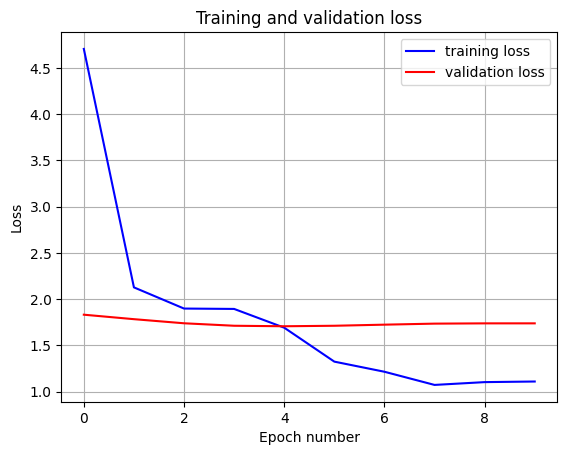

In [ ]:
# save model
model.save(folder_path + "/model.keras")

#  save training history
plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.grid(True)
plt.legend()

path = folder_path + '/training_history.png'
plt.savefig(path, format='png', dpi=300)
plt.show()  

In [ ]:
test_pred = model.predict(X_test)

mse = mean_squared_error(test_pred, Y_test)
mae = mean_absolute_error(test_pred, Y_test)
print(f"Mean Squared Error: {mse:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Mean Squared Error: 1.521
Mean Absolute Error: 0.785


In [ ]:
from utils.model_analysis import complete_model_analysis_mlp

# complete_model_analysis_mlp("../../outputs/mlp/2025-09-23_14-57","exp1")
complete_model_analysis_mlp(folder_path,"exp1")
complete_model_analysis_mlp(folder_path,"exp3")
complete_model_analysis_mlp(folder_path,"exp5")


ValueError: File not found: filepath=../../outputs/mlp/2025-09-23_14-57/model.keras. Please ensure the file is an accessible `.keras` zip file.